# PyTorch Hypercolumn CNN  for Zurich Dataset

In [1]:
# import libraries
import pandas as pd
import os, sys
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn import metrics
from torch.utils.data import DataLoader
from tqdm import tqdm_notebook as tqdm
import numpy as np
import gc
from helpers_pytorch import *

# custom libraries
base_dir = '/raid/home/cwendl'  # for guanabana
sys.path.append(base_dir + '/SIE-Master/Code')  # Path to density Tree package
from helpers.data_loader import ZurichLoader
from helpers.helpers import *
from hypercolumn import HyperColumn

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
# load datasets
base_dir = '/raid/home/cwendl'  # for guanabana
root_dir = base_dir + '/SIE-Master/Zurich'
patch_size = 64
class_to_remove = 3

# load data
dataset_train = ZurichLoader(root_dir, 'train', patch_size=patch_size, stride=patch_size, transform='augment',
                             class_to_remove=class_to_remove)
dataset_val = ZurichLoader(root_dir, 'val', patch_size=patch_size, stride=patch_size,
                           class_to_remove=class_to_remove)
dataset_test = ZurichLoader(root_dir, 'test', patch_size=patch_size, stride=patch_size,
                            class_to_remove=class_to_remove)

dataloader_train = DataLoader(dataset_train, batch_size=100, shuffle=True, num_workers=20)
dataloader_val = DataLoader(dataset_val, batch_size=100, shuffle=False, num_workers=20)
dataloader_test = DataLoader(dataset_test, batch_size=100, shuffle=False, num_workers=20)

# load patches with overlap (for prediction)
dataset_train_overlap = ZurichLoader(root_dir, 'train', patch_size=patch_size, stride=int(patch_size/2), 
                                     inherit_loader=dataset_train)
dataset_val_overlap = ZurichLoader(root_dir, 'val', patch_size=patch_size, stride=int(patch_size/2), 
                                   inherit_loader=dataset_val)
dataset_test_overlap = ZurichLoader(root_dir, 'test', patch_size=patch_size, stride=int(patch_size/2), 
                                    inherit_loader=dataset_test)

dataloader_train_overlap = DataLoader(dataset_train_overlap, batch_size=100, shuffle=False, num_workers=40)
dataloader_val_overlap = DataLoader(dataset_val_overlap, batch_size=100, shuffle=False, num_workers=40)
dataloader_test_overlap = DataLoader(dataset_test_overlap, batch_size=100, shuffle=False, num_workers=40)

In [3]:
# train or load CNN model
train_bool = False

model = HyperColumn(in_dim=4, out_dim=9, n_filters=32, patch_size=patch_size).cuda()
if train_bool:
    train(model, dataloader_train, dataloader_val, epochs=300, verbosity=1, plot=True, class_to_remove=class_to_remove)
    
    # save model
    state = {'model': model.state_dict(), 
             'n_epochs': 50,
             'loss_tr':0.
            }
    torch.save(state, 'models/model_wo_cl_' + str(class_to_remove) + '.pytorch')
    
else:  # load saved model
    state = torch.load('models/model_wo_cl_' + str(class_to_remove) + '.pytorch')
    model.load_state_dict(state['model'])

In [4]:
# predict

# train
preds_tr = predict_softmax(model, dataloader_train_overlap)
preds_tr = remove_overlap(dataset_train.imgs, preds_tr, np.arange(10), patch_size=patch_size, stride=int(patch_size/2))
preds_tr = np.concatenate(preds_tr)

# val
preds_val = predict_softmax(model, dataloader_val_overlap)
preds_val = remove_overlap(dataset_val.imgs, preds_val, np.arange(5), patch_size=patch_size, stride=int(patch_size/2))
preds_val = np.concatenate(preds_val)

# test
preds_te = predict_softmax(model, dataloader_test_overlap)
preds_te = remove_overlap(dataset_test.imgs, preds_te, np.arange(5), patch_size=patch_size, stride=int(patch_size/2))
preds_te = np.concatenate(preds_te)

145it [00:13, 11.02it/s]
47it [00:03, 14.22it/s]
48it [00:03, 14.85it/s]


In [5]:
# free GPU memory
while gc.collect():
    torch.cuda.empty_cache()

In [6]:
# get labels
pred_labels_tr = get_y_pred_labels(preds_tr, class_to_remove=class_to_remove, background=False)
pred_labels_val = get_y_pred_labels(preds_val, class_to_remove=class_to_remove, background=False)
pred_labels_te = get_y_pred_labels(preds_te, class_to_remove=class_to_remove, background=False)

In [7]:
# get indices of correctly / incorrectly predicted pixels
# train
pred_t_tr = (dataset_train.gt_patches != class_to_remove) & (dataset_train.gt_patches != 0)
pred_f_tr = dataset_train.gt_patches == class_to_remove

# val
pred_t_val = (dataset_val.gt_patches != class_to_remove) & (dataset_val.gt_patches != 0)
pred_f_val = dataset_val.gt_patches == class_to_remove

# test
pred_t_te = (dataset_test.gt_patches != class_to_remove) & (dataset_test.gt_patches != 0)
pred_f_te = dataset_test.gt_patches == class_to_remove

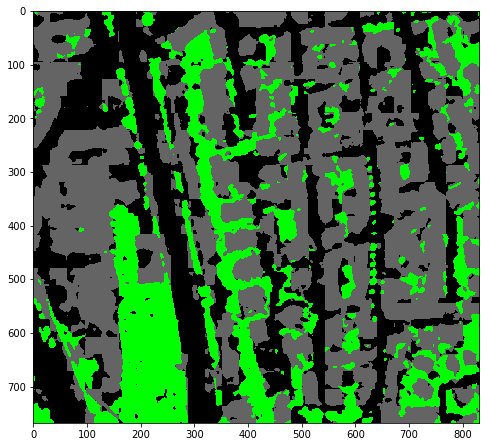

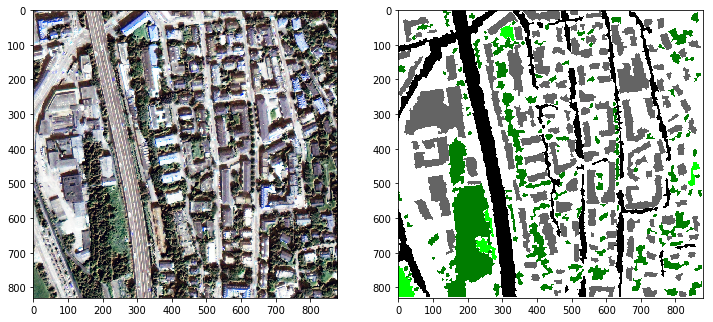

In [8]:
img_idx = 1

img = convert_patches_to_image(dataset_train.imgs, pred_labels_tr[..., np.newaxis], img_idx, patch_size, patch_size, 0)

# pred
plt.figure(figsize=(8, 8))
plt.imshow(gt_label_to_color(img[..., 0], dataset_train.colors)*255)
plt.show()

# im
fig, axes = plt.subplots(1, 2, figsize=(12, 7))
axes[0].imshow(dataset_train.imgs[img_idx][..., :3])
axes[1].imshow(gt_label_to_color(dataset_train.gt[img_idx], dataset_train.colors)*255)
plt.show()

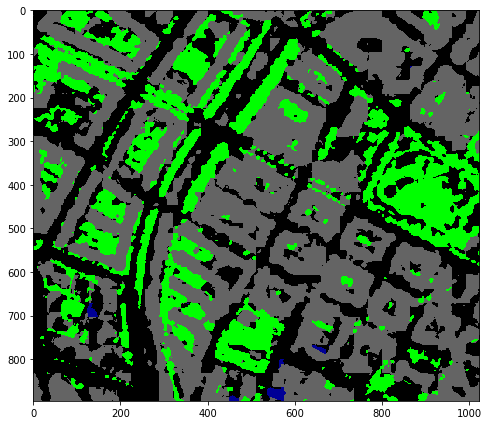

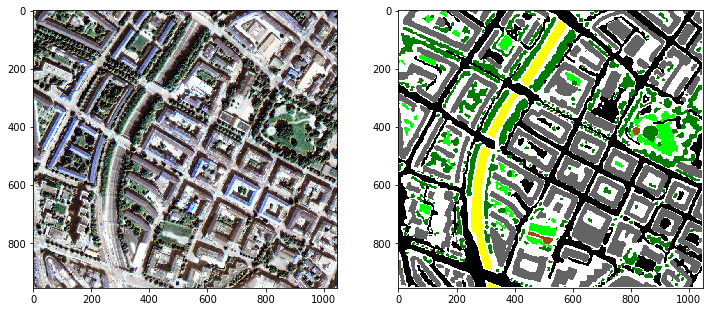

In [9]:
img_idx = 2

img = convert_patches_to_image(dataset_val.imgs, pred_labels_val[..., np.newaxis], img_idx, patch_size, patch_size, 0)

# pred
plt.figure(figsize=(8, 8))
plt.imshow(gt_label_to_color(img[..., 0], dataset_val.colors)*255)
plt.show()

# im
fig, axes = plt.subplots(1, 2, figsize=(12, 7))
axes[0].imshow(dataset_val.imgs[img_idx][..., :3])
axes[1].imshow(gt_label_to_color(dataset_val.gt[img_idx], dataset_val.colors)*255)
plt.show()

In [10]:
# class names and colors
names = dataset_train.names
colors = dataset_train.colors
n_classes = 9
classes_to_keep = np.asarray([x for x in range(1, n_classes) if x != class_to_remove])
names_keep = np.asarray(names)[classes_to_keep]
print("classes to keep: " + str(names_keep))

classes to keep: ['Roads' 'Buildings' 'Grass' 'Bare Soil' 'Water' 'Railways'
 'Swimming Pools']


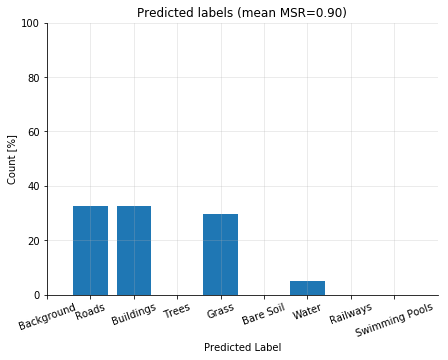

In [11]:
# distribution of predicted labels in test set
pred_labels, pred_counts = np.unique(pred_labels_te, return_counts=True)
pred_counts = pred_counts / sum(pred_counts) * 100

# visualization
fig = plt.figure(figsize=(7, 5))
plt.bar(pred_labels, pred_counts)
plt.xticks(np.arange(0, 10))
plt.ylim([0, 100])
plt.xlabel("Predicted Label")
plt.ylabel("Count [%]")
plt.grid(alpha=.3)
fig.axes[0].spines['right'].set_visible(False)
fig.axes[0].spines['top'].set_visible(False)
plt.title("Predicted labels")
plt.xticks(np.arange(len(names)), names, rotation=20)
plt.show()

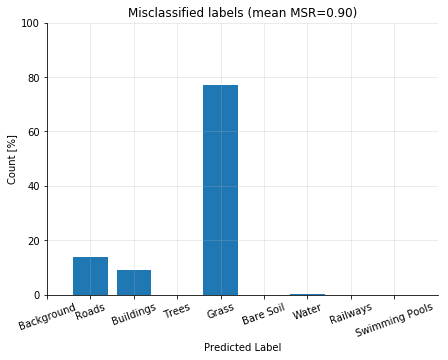

In [12]:
# distribution of predicted label that were misclassified
pred_labels, pred_counts = np.unique(pred_labels_te[pred_f_te], return_counts=True)
pred_counts = pred_counts / sum(pred_counts) * 100

# visualization
fig = plt.figure(figsize=(7, 5))
plt.bar(pred_labels, pred_counts)
plt.xticks(np.arange(0, 10))
plt.ylim([0, 100])
plt.xlabel("Predicted Label")
plt.ylabel("Count [%]")
plt.grid(alpha=.3)
fig.axes[0].spines['right'].set_visible(False)
fig.axes[0].spines['top'].set_visible(False)
plt.title("Misclassified labels (mean MSR=%.2f)" % np.mean(get_acc_net_msr(preds_te[pred_f_te])))
plt.xticks(np.arange(len(names)), names, rotation=20)
plt.savefig("Figures/Pred_count/ZH_pred-count_wo_cl" + str(class_to_remove) + ".pdf",
            bbox_inches='tight', pad_inches=0)

In [13]:
# TODO get weights
# p = [p for p in model.parameters()]
# for p_ in p:
    # print(p_.cpu().detach().numpy().shape)

In [14]:
ones = np.ones(len(np.unique(dataset_train.gt_patches)))
ones[0] = 0
weight = torch.from_numpy(ones).float().cuda()
f_loss = nn.CrossEntropyLoss(weight=weight)
p = test(model, f_loss, dataloader_train, "Train", verbosity=1)
p = test(model, f_loss, dataloader_val, "Val", verbosity=1)
p = test(model, f_loss, dataloader_test, "Test", verbosity=1)

Train set: Average loss: 0.0159, Accuracy: 81.82%
Val set: Average loss: 0.0162, Accuracy: 79.50%
Test set: Average loss: 0.0159, Accuracy: 79.85%


In [15]:
# Accuracy measures for each class
y_preds = [pred_labels_tr, pred_labels_val, pred_labels_te]
datasets = [dataset_train, dataset_val, dataset_test]

aa_sets, oa_sets = [], []
for y_pred, y_true in zip(y_preds, datasets):
    y_pred_flattened = np.asarray(y_pred.flatten()).astype('int') 
    y_true_flattened = np.asarray(y_true.gt_patches.flatten()).astype('int') 

    # mask background and removed classes for evaluation metrics
    filter_items = (y_true_flattened != 0) & (y_true_flattened != class_to_remove)
    
    aa_set, _ = aa(y_true_flattened[filter_items], y_pred_flattened[filter_items])
    oa_set = oa(y_true_flattened[filter_items], y_pred_flattened[filter_items])
    print("OA: %.3f, AA: %.3f" % (oa_set, aa_set))  # slightly higher accuracy because of overlapping patches
    oa_sets.append(oa_set)
    aa_sets.append(aa_set)

OA: 0.847, AA: 0.888
OA: 0.814, AA: 0.859
OA: 0.824, AA: 0.857


In [16]:
# TODO save CSV
# write metrics to CSV files
df_metrics = pd.read_csv('models/metrics_ND.csv', index_col=0)
accs = np.concatenate([[oa_sets[i], aa_sets[i]] for i in range(3)])  # [oa, aa] for tr, val, te
df2 = pd.DataFrame({str(names[class_to_remove]):accs},
                   index = ['OA Train', 'AA Train', 'OA Val', 'AA Val', 'OA Test', 'AA Test']).T
df_metrics = df_metrics.append(df2)
df_metrics = df_metrics[~df_metrics.index.duplicated(keep='last')]  # avoid duplicates
df_metrics.to_csv('models/metrics_ND.csv')
print((df_metrics*100).round(2).to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &  OA Train &  AA Train &  OA Val &  AA Val &  OA Test &  AA Test \\
\midrule
Bare Soil                                          &     71.99 &     71.49 &   73.78 &   65.45 &    71.83 &    64.40 \\
Water                                              &     69.42 &     61.42 &   67.09 &   52.39 &    69.84 &    55.40 \\
Railways                                           &     74.47 &     79.01 &   71.17 &   73.57 &    72.87 &    79.15 \\
Swimming Pools                                     &     70.80 &     66.04 &   67.94 &   56.11 &    69.17 &    64.45 \\
Grass                                              &     72.13 &     67.55 &   72.44 &   63.90 &    72.58 &    63.72 \\
Buildings                                          &     87.74 &     91.18 &   89.10 &   91.83 &    82.08 &    86.36 \\
[['Background' 'Roads' 'Buildings' 'Trees' 'Gra... &     83.47 &     87.14 &   80.04 &   83.27 &    77.49 &    80.74 \\
Roads                                        

# Network

In [18]:
# precision-recall curves
y_true = pred_f_te.flatten()

# msr
y_scores = (-get_acc_net_msr(preds_te)).flatten()
precision_msr, recall_msr, _ = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_msr = metrics.average_precision_score(y_true, y_scores)
auroc_msr = metrics.roc_auc_score(y_true, y_scores)
fpr_msr, tpr_msr, _ = metrics.roc_curve(y_true, y_scores)

# margin
y_scores = (-get_acc_net_max_margin(preds_te)).flatten()
precision_margin, recall_margin, _ = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_margin = metrics.average_precision_score(y_true, y_scores)
auroc_margin = metrics.roc_auc_score(y_true, y_scores)
fpr_margin, tpr_margin, _ = metrics.roc_curve(y_true, y_scores)

# entropy
y_scores = (-get_acc_net_entropy(preds_te)).flatten()
precision_entropy, recall_entropy, _ = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_entropy = metrics.average_precision_score(y_true, y_scores)
auroc_entropy = metrics.roc_auc_score(y_true, y_scores)
fpr_entropy, tpr_entropy, _ = metrics.roc_curve(y_true, y_scores)

print("AUROC: %.2f, PR AUC: %.2f" % (auroc_msr, pr_auc_msr))
print("AUROC: %.2f, PR AUC: %.2f" % (auroc_margin, pr_auc_margin))
print("AUROC: %.2f, PR AUC: %.2f" % (auroc_entropy, pr_auc_entropy))

AUROC: 0.65, PR AUC: 0.18
AUROC: 0.64, PR AUC: 0.17
AUROC: 0.66, PR AUC: 0.20


In [20]:
# visualization
# MSR
probas_patches_msr = np.reshape((get_acc_net_msr(preds_te)).flatten(), np.shape(dataset_test.gt_patches))
probas_patches_msr -= np.min(probas_patches_msr)
probas_patches_msr /= np.max(probas_patches_msr)

# margin
probas_patches_margin = np.reshape((get_acc_net_max_margin(preds_te)).flatten(), np.shape(dataset_test.gt_patches))
probas_patches_margin -= np.min(probas_patches_margin)
probas_patches_margin /= np.max(probas_patches_margin)

# entropy
probas_patches_entropy = np.reshape((get_acc_net_entropy(preds_te)).flatten(), np.shape(dataset_test.gt_patches))
probas_patches_entropy -= np.min(probas_patches_entropy)
probas_patches_entropy /= np.max(probas_patches_entropy)

base_folder = "Figures/Im_cert/cl_" + str(class_to_remove)

# show images
for img_idx in range(len(dataset_test.imgs)):
    acc_im_msr = convert_patches_to_image(dataset_test.imgs, probas_patches_msr[..., np.newaxis], img_idx, 64, 64, 0)
    acc_im_msr = imgs_stretch_eq([acc_im_msr])[0]
    plt.figure(figsize=(8, 8))
    plt.imshow(acc_im_msr[..., 0], cmap='RdYlGn')
    plt.axis('off')
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.savefig(base_folder + "/ZH_wo_cl_" + str(class_to_remove) + "_net_msr_im_" + str(img_idx) + ".pdf", 
                bbox_inches='tight', pad_inches=0)
    plt.close()
    
    acc_im_margin = convert_patches_to_image(dataset_test.imgs, probas_patches_margin[..., np.newaxis],
                                             img_idx, 64, 64, 0)
    acc_im_margin = imgs_stretch_eq([acc_im_margin])[0]
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.imshow(acc_im_margin[..., 0], cmap='RdYlGn')
    plt.savefig(base_folder + "/ZH_wo_cl_" + str(class_to_remove) + "_net_margin_im_" + str(img_idx) + ".pdf", 
                bbox_inches='tight', pad_inches=0)
    plt.close()
    
    acc_im_entropy = convert_patches_to_image(dataset_test.imgs, probas_patches_entropy[..., np.newaxis],
                                              img_idx, 64, 64, 0)
    acc_im_entropy = imgs_stretch_eq([acc_im_entropy])[0]
    plt.figure(figsize=(8, 8))
    plt.imshow(acc_im_entropy[..., 0], cmap='RdYlGn')
    plt.axis('off')
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.savefig(base_folder + "/ZH_wo_cl_" + str(class_to_remove) + "_net_entropy_im_" + str(img_idx) + ".pdf", 
                bbox_inches='tight', pad_inches=0)
    plt.close()

# Dropout

In [21]:
# get softmax scores with dropout
n_iters = 10
probas_dropout = predict_softmax_w_dropout(model, dataloader_test, n_iters)

100%|██████████| 10/10 [00:27<00:00,  2.78s/it]


AUROC: 0.53, PR AUC: 0.16


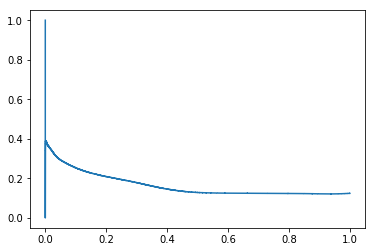

In [22]:
# metrics
y_scores = -get_acc_net_entropy(np.mean(probas_dropout, 0)).flatten()

# PR
precision_dropout, recall_dropout, _ = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_dropout = metrics.auc(recall_dropout, precision_dropout)

# ROC
fpr_dropout, tpr_dropout, _ = metrics.roc_curve(y_true, y_scores)
auroc_dropout = metrics.roc_auc_score(y_true, y_scores)
plt.step(recall_dropout, precision_dropout)
print("AUROC: %.2f, PR AUC: %.2f" % (auroc_dropout, pr_auc_dropout))

In [23]:
# clear CUDA storage
while gc.collect():
    torch.cuda.empty_cache()

In [24]:
# export images
probas_patches_dropout = np.reshape(y_scores, np.shape(dataset_test.gt_patches))
probas_patches_dropout -= np.min(probas_patches_dropout)
probas_patches_dropout /= np.max(probas_patches_dropout)

# show image of DF uncertainty vs. max margin uncertainty
for img_idx in range(len(dataset_test.imgs)):
    acc_im_dropout = convert_patches_to_image(dataset_test.imgs, probas_patches_dropout[..., np.newaxis], img_idx, 64, 64, 0)
    acc_im_dropout = imgs_stretch_eq([acc_im_dropout])[0]
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.imshow(acc_im_dropout[..., 0], cmap='RdYlGn')
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.savefig(base_folder + "/ZH_wo_cl_" + str(class_to_remove) + "_dropout_im_" + str(img_idx) + ".pdf", 
                bbox_inches='tight', pad_inches=0)
    plt.close()

# Retrieve Activations

In [25]:
act_val = get_activations(model, dataloader_val_overlap, 64)

47it [00:20,  2.33it/s]


In [26]:
del dataset_val_overlap, dataloader_val_overlap

## PCA

In [27]:
# python libraries
from sklearn.manifold import TSNE
from sklearn import decomposition, svm, preprocessing
from sklearn.mixture import GaussianMixture
from sklearn.gaussian_process.kernels import RBF
from sklearn import metrics

# custom libraries
from helpers.parameter_search import *
from density_forest.density_forest import *
from density_forest.plots import *
from density_forest.helpers import *

Using TensorFlow backend.


In [28]:
print(np.shape(draw_subsamples(act_val, .1)))
print(np.shape(np.concatenate(np.concatenate(draw_subsamples(act_val, .1)))))

(117, 64, 64, 484)
(479232, 484)


In [29]:
ind_bal = get_balanced_subset_indices(dataset_test.gt_patches.flatten(), np.arange(1, 9)).flatten()

In [30]:
# create density tree for activation weights of training data
# PCA
pca = decomposition.PCA(n_components=.95)

# TODO fit on training set without background pixels
pca.fit(draw_subsamples(np.concatenate(np.concatenate(draw_subsamples(act_val, .1)))))  
n_components = np.alen(pca.explained_variance_ratio_)
print("Variance explained by first %i components: %.2f" % (
    n_components, sum(pca.explained_variance_ratio_)))

Variance explained by first 69 components: 0.95


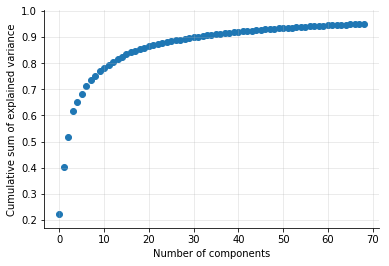

In [31]:
# Plot cumulative explained variance
fig = plt.figure()
plt.scatter(np.arange(n_components), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cumulative sum of explained variance")
plt.grid(alpha=.3)
fig.axes[0].spines['right'].set_visible(False)
fig.axes[0].spines['top'].set_visible(False)
plt.savefig("Figures/PCA/pca_components_wo_cl_" + str(class_to_remove) + ".pdf",
            bbox_inches='tight', pad_inches=0)

In [32]:
act_val = pca.transform(np.concatenate(np.concatenate(act_val)))[..., :10]

In [33]:
# get other activations

# test
act_test = get_activations(model, dataloader_test_overlap, 64)
print(np.shape(act_test))

# PCA 
act_test = pca.transform(np.concatenate(np.concatenate(act_test)))[..., :10]
print(np.shape(act_test))
del dataset_test_overlap, dataloader_test_overlap

48it [00:23,  2.04it/s]


(1185, 64, 64, 484)
(4853760, 10)


In [34]:
# t-SNE visualization
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=500)
tsne_all = tsne.fit_transform(act_test[ind_bal])
tsne_y = dataset_test.gt_patches.flatten()[ind_bal]

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 800 samples in 0.001s...
[t-SNE] Computed neighbors for 800 samples in 0.035s...
[t-SNE] Computed conditional probabilities for sample 800 / 800
[t-SNE] Mean sigma: 0.343565
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.182472
[t-SNE] Error after 500 iterations: 0.426666


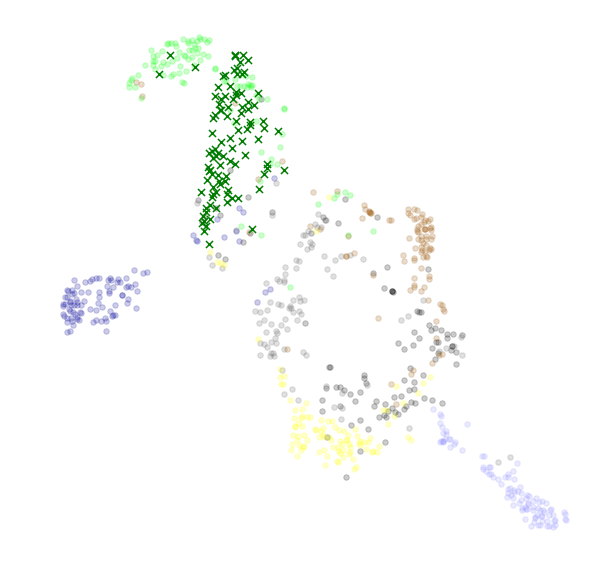

In [35]:
# plot
_, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_axis_off()
plot_pts_2d(tsne_all, tsne_y, ax, classes_to_keep, colors, class_to_remove=class_to_remove)
plt.savefig("Figures/tSNE/t-SNE_" + str(names[class_to_remove]).lower().replace(" ", "") + "_after_PCA.pdf",
            bbox_inches='tight', pad_inches=0)

In [36]:
# clear CUDA storage
while gc.collect():
    torch.cuda.empty_cache()

In [37]:
# get other activations

# train
act_train = get_activations(model, dataloader_train_overlap, 64, pca)
print(act_train.shape)

145it [02:21,  1.03it/s]


(14831616, 10)


In [38]:
del dataset_train_overlap, dataloader_train_overlap

In [39]:
# clear CUDA storage
while gc.collect():
    torch.cuda.empty_cache()

# Confidence Estimation using Network Embeddings

# GMM

In [40]:
# Fit GMM
gmm = GaussianMixture(n_components=6, max_iter=10000)
gmm.fit(draw_subsamples(act_train[pred_t_tr.flatten()], .01))

# Predict
probas_gmm = gmm.predict_proba(act_test)
probas_gmm = get_acc_net_entropy(probas_gmm)

AUROC: 0.44, PR AUC: 0.11


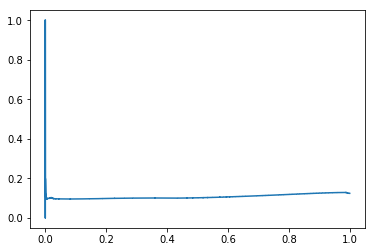

In [41]:
# metrics
y_true = pred_f_te.flatten()
y_scores = -probas_gmm

# PR
precision_gmm, recall_gmm, _ = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_gmm = metrics.auc(recall_gmm, precision_gmm)

# ROC
fpr_gmm, tpr_gmm, _ = metrics.roc_curve(y_true, y_scores)
auroc_gmm = metrics.roc_auc_score(y_true, y_scores)
plt.step(recall_gmm, precision_gmm)
print("AUROC: %.2f, PR AUC: %.2f" % (auroc_gmm, pr_auc_gmm))

In [42]:
# visualization
probas_patches_gmm = np.reshape(y_scores, np.shape(dataset_test.gt_patches))
probas_patches_gmm -= np.min(probas_patches_gmm)
probas_patches_gmm /= np.max(probas_patches_gmm)

# show image of DF uncertainty vs. max margin uncertainty
for img_idx in range(len(dataset_test.imgs)):
    acc_im_gmm = convert_patches_to_image(dataset_test.imgs, probas_patches_gmm[..., np.newaxis], img_idx, 64, 64, 0)
    acc_im_gmm = imgs_stretch_eq([acc_im_gmm])[0]
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.imshow(acc_im_gmm[..., 0], cmap='RdYlGn')
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.savefig(base_folder + "/ZH_wo_cl_" + str(class_to_remove) + "_gmm_im_" + str(img_idx) + ".pdf", 
                bbox_inches='tight', pad_inches=0)
    plt.close()

# SVM

In [43]:
act_train_svm = preprocessing.scale(act_train)
# act_val_svm = preprocessing.scale(act_val)
act_test_svm = preprocessing.scale(act_test)

In [44]:
# Fit SVM
# TODO test limitation to 5 components
max_dim = 5
clf_svm = svm.OneClassSVM(kernel='rbf', max_iter=10000, verbose=True)
clf_svm.fit(draw_subsamples(act_train_svm[pred_t_tr.flatten(), :max_dim], .001))

[LibSVM]

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='auto', kernel='rbf',
      max_iter=10000, nu=0.5, random_state=None, shrinking=True, tol=0.001,
      verbose=True)

In [45]:
# predict
probas_svm = clf_svm.decision_function(act_test_svm[..., :max_dim])
probas_svm -= np.min(probas_svm)
probas_svm /= np.max(probas_svm)

In [46]:
# metrics

y_scores = -probas_svm[:]
# PR
precision_svm, recall_svm, _ = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_svm = metrics.auc(recall_svm, precision_svm)

# ROC
fpr_svm, tpr_svm, _ = metrics.roc_curve(y_true, y_scores)
auroc_svm = metrics.roc_auc_score(y_true, y_scores)

print("AUROC: %.2f, PR AUC: %.2f" % (auroc_svm, pr_auc_svm))

AUROC: 0.40, PR AUC: 0.09


## Density Forest

In [47]:
# Create DensityForest instance
clf_df = DensityForest(max_depth=2, min_subset=0, n_trees=20,
                       subsample_pct=.0001, n_jobs=-1, verbose=10, batch_size=10000)

In [48]:
clf_df.fit(act_train[pred_t_tr.flatten()])

Number of points on which to train each tree: 744
Minimum number of points in each leaf: 0


[Parallel(n_jobs=40)]: Done   4 out of  20 | elapsed:   26.7s remaining:  1.8min
[Parallel(n_jobs=40)]: Done   7 out of  20 | elapsed:   27.5s remaining:   51.1s
[Parallel(n_jobs=40)]: Done  10 out of  20 | elapsed:   27.8s remaining:   27.8s
[Parallel(n_jobs=40)]: Done  13 out of  20 | elapsed:   29.1s remaining:   15.7s
[Parallel(n_jobs=40)]: Done  16 out of  20 | elapsed:   29.6s remaining:    7.4s
[Parallel(n_jobs=40)]: Done  20 out of  20 | elapsed:   30.0s finished


Number of created root nodes: 20
Mean number of clusters created per tree: 8


In [49]:
probas_df = clf_df.predict(act_test)

Total steps: 485
Number of jobs: 40 


[Parallel(n_jobs=40)]: Done   5 tasks      | elapsed:    5.1s
[Parallel(n_jobs=40)]: Done  18 tasks      | elapsed:    6.8s
[Parallel(n_jobs=40)]: Done  33 tasks      | elapsed:    7.4s
[Parallel(n_jobs=40)]: Done  48 tasks      | elapsed:   10.4s
[Parallel(n_jobs=40)]: Done  65 tasks      | elapsed:   11.8s
[Parallel(n_jobs=40)]: Done  82 tasks      | elapsed:   13.6s
[Parallel(n_jobs=40)]: Done 101 tasks      | elapsed:   16.5s
[Parallel(n_jobs=40)]: Done 120 tasks      | elapsed:   18.2s
[Parallel(n_jobs=40)]: Done 141 tasks      | elapsed:   21.5s
[Parallel(n_jobs=40)]: Done 162 tasks      | elapsed:   24.3s
[Parallel(n_jobs=40)]: Done 185 tasks      | elapsed:   26.7s
[Parallel(n_jobs=40)]: Done 208 tasks      | elapsed:   30.0s
[Parallel(n_jobs=40)]: Done 233 tasks      | elapsed:   32.6s
[Parallel(n_jobs=40)]: Done 258 tasks      | elapsed:   35.7s
[Parallel(n_jobs=40)]: Done 285 tasks      | elapsed:   39.0s
[Parallel(n_jobs=40)]: Done 312 tasks      | elapsed:   42.3s
[Paralle

In [50]:
# metrics
y_scores = -probas_df

# PR
precision_df, recall_df, _ = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_df = metrics.auc(recall_df, precision_df)

# ROC
fpr_df, tpr_df, _ = metrics.roc_curve(y_true, y_scores)
auroc_df = metrics.roc_auc_score(y_true, y_scores)

print("AUROC: %.2f, PR AUC: %.2f" % (auroc_df, pr_auc_df))

AUROC: 0.30, PR AUC: 0.08


In [51]:
# visualization
probas_patches_df = np.reshape(probas_df, np.shape(dataset_test.gt_patches))
probas_patches_df -= np.min(probas_patches_df)
probas_patches_df /= np.max(probas_patches_df)

# show image of DF uncertainty vs. max margin uncertainty
for img_idx in range(len(dataset_test.imgs)):
    acc_im_df = convert_patches_to_image(dataset_test.imgs, probas_patches_df[..., np.newaxis], img_idx, 64, 64, 0)
    acc_im_df = imgs_stretch_eq([acc_im_df])[0]
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.imshow(acc_im_df[..., 0], cmap='RdYlGn')
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.savefig(base_folder + "/ZH_wo_cl_" + str(class_to_remove) + "_df_im_" + str(img_idx) + ".pdf", 
                bbox_inches='tight', pad_inches=0)
    plt.close()

# Plots

In [52]:
# Precision-Recall Curve
# order according to increasing score
scores_pr = [pr_auc_msr, pr_auc_margin, pr_auc_entropy, pr_auc_dropout, pr_auc_gmm, pr_auc_svm, pr_auc_df]

recalls = [recall_msr, recall_margin, recall_entropy, recall_dropout, recall_gmm, recall_svm, recall_df]
precisions = [precision_msr, precision_margin, precision_entropy, precision_dropout, 
              precision_gmm, precision_svm, precision_df]

names_methods = np.array(['MSR', 'Margin', 'Entropy', 'Dropout', 'GMM', 'OC SVM', 'DF'])
scores_order = np.argsort(scores_pr)
colors_lines = plt.cm.rainbow(np.linspace(0, 1, len(scores_pr)))[:, :3]

# plot
fig = plt.figure(figsize=(6, 6))
for i in scores_order:
    plt.step(recalls[i], precisions[i], where='post', c=colors_lines[i])

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.grid(alpha=.3)
fig.axes[0].spines['right'].set_visible(False)
fig.axes[0].spines['top'].set_visible(False)
plt.legend([str.format('%s: %.2f') % (names_methods[i], scores_pr[i]) for i in scores_order], title="PR AUC")
plt.savefig("Figures/Metrics/PR_pred_wo_cl_" + str(class_to_remove) + ".pdf", bbox_inches='tight', pad_inches=0)
plt.close()

In [53]:
# ROC
# order according to increasing score
scores_auc = [auroc_msr, auroc_margin, auroc_entropy, auroc_dropout, auroc_gmm, auroc_svm, auroc_df]
fprs = [fpr_msr, fpr_margin, fpr_entropy, fpr_dropout, fpr_gmm, fpr_svm, fpr_df]
tprs = [tpr_msr, tpr_margin, tpr_entropy, tpr_dropout, tpr_gmm, tpr_svm, tpr_df]
scores_order = np.argsort(scores_auc)
colors_lines = plt.cm.rainbow(np.linspace(0, 1, len(scores_auc)))[:, :3]

# plot
fig = plt.figure(figsize=(6, 6))
for i in scores_order:
    plt.step(fprs[i], tprs[i], where='post', c=colors_lines[i])

plt.plot([0, 1], [0, 1], '--', c='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.grid(alpha=.3)
fig.axes[0].spines['right'].set_visible(False)
fig.axes[0].spines['top'].set_visible(False)
plt.legend([str.format('%s: %.2f') % (names_methods[i], scores_auc[i]) for i in scores_order], title="AUROC")
plt.savefig("Figures/Metrics/ROC_pred_wo_cl_" + str(class_to_remove) + ".pdf", bbox_inches='tight', pad_inches=0)
plt.close()